# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import scipy.stats as stats

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


### Question #1: Does the Central Limit Theorem Apply?

For the Central Limit Theorem to apply, the number of successes or failures (callbacks or not) needs to be greater than or equal to 10. In this case, since there are 235 callbacks for white-sounding names, and 157 call-backs for black-sounding names, we can say the CLT applies.

### Null Hypothesis: Race has no effect on callbacks.
### Alternate Hypothesis: Race has an effect on callbacks.

In [5]:
w = data[data.race=='w']
b = data[data.race=='b']

In [6]:
def bs_rep_1d(data, func, ssize):
    """ Bootstrap function. Resamples input data and applies a function (e.g. mean) """
    bs = np.random.choice(data,ssize)
    return func(bs)

def draw_bs_reps(data,func,size,ssize):
    """ Collects many boostrapped samples """
    return np.array([bs_rep_1d(data,func,ssize) for _ in range(size)])

In [27]:
# Calculate mean and standard deviation for w and b.
n = len(data)
wc = w.call
bc = b.call
w_mean = wc.mean()
w_std = wc.std()
b_mean = bc.mean()
b_std = bc.std()
w_n = len(wc)
b_n = len(bc)
gdiff = np.abs(w_mean-b_mean)
gdiff

0.03203285485506058

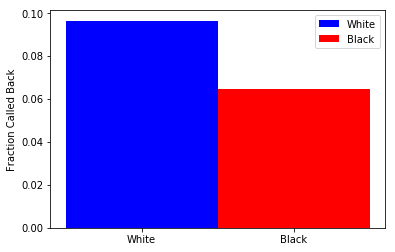

In [8]:
fig, ax = plt.subplots()
plt.bar(np.array([1])-.15,w_mean,color='blue',width=0.3)
plt.bar(np.array([1])+.15,b_mean,color='red',width=0.3)
ax.set_xticks([0.85,1.15])
ax.set_xticklabels(['White', 'Black'])
plt.ylabel('Fraction Called Back')
plt.legend(['White','Black'])

### The fraction of people called back is higher for 'w' than for 'b', but it's not clear if the difference is significant. 

In [24]:
# Using the combined white and black observations, extract random samples for each subset population.
# Calculate the difference in means, and repeat 10,000 times, storing in 'tstat' variable.
MW = data.call
lenm = len(w)
N = 10000
tstat = np.empty(N)
for i in range(N):
    MWp = np.random.permutation(MW)
    Mp = MWp[:lenm]
    Wp = MWp[lenm:]
    tstat[i] = np.mean(Mp) - np.mean(Wp)

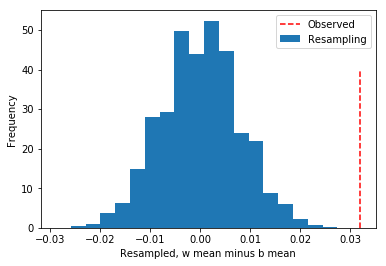

In [25]:
# Plot the histogram of the distribution of the difference.
# The red dotted lines represent the observed difference, in both directions.
plt.hist(tstat,density=True,bins=20)
#plt.plot([-gdiff,-gdiff],[0,40],linestyle='--',color='r')
plt.plot([gdiff,gdiff],[0,40],linestyle='--',color='r')
plt.xlabel('Resampled, w mean minus b mean')
plt.ylabel('Frequency')
plt.legend(['Observed','Resampling'],loc='upper right')

In [26]:
pvalue = np.sum(tstat >= gdiff) / len(tstat)
pvalue

0

### From the histogram above, we see that the observed difference in callback fraction (the red dotted line) between 'w' and 'b' is extremely unlikely to have occurred by chance.

### Now we'll try a frequentist approach, with a 95% confidence interval, or z* = 1.96
$$z = \frac{(\bar{x}_W - \bar{x}_B) - 0}{\sqrt{\frac{\sigma_W^2}{n_W} + \frac{\sigma_B^2}{n_B}}}$$

In [29]:
z = (w_mean - b_mean)/np.sqrt((w_std**2)/w_n + (b_std**2)/b_n)
z

4.114738324427747

### The calculated z is much larger than z* for a 95% confidence interval, which means we can reject the null hypothesis. It is thus likely that the difference in call backs between white and black applicants is statistically significant.